# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.callbacks import ModelCheckpoint

2024-07-18 12:57:34.997774: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 12:57:35.003131: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 12:57:35.013135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 12:57:35.030190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 12:57:35.030217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 12:57:35.043827: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
# read the data
df_sales = pd.read_csv("~/shared/rcac_mlai_timeseries/sales_train_validation.csv")
df_calender = pd.read_csv("~/shared/rcac_mlai_timeseries/calendar.csv")
df_price = pd.read_csv("~/shared/rcac_mlai_timeseries/sell_prices.csv")
df_price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [3]:
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


# Visualizing the data for one particular product

<Axes: >

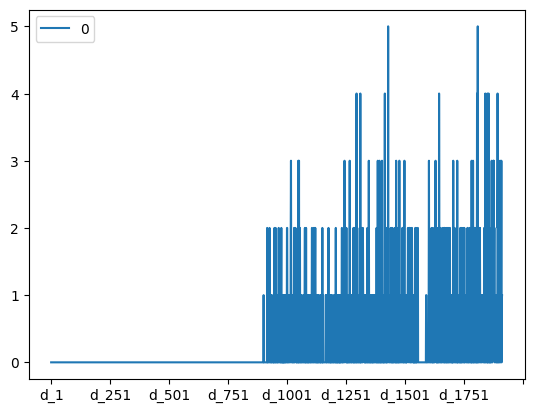

In [4]:
df_sales[df_sales['id']=='HOBBIES_1_001_CA_1_validation'].T.iloc[6:].plot()

# Selecting a sub-category within our data, but at a higher level, say foods 1 in store CA_1

In [5]:
df_ca_foods_1 = df_sales[(df_sales['cat_id']=='FOODS')
                         &(df_sales['dept_id']=='FOODS_1')
                         &(df_sales['store_id']=='CA_1')]

In [6]:
foods_1 = df_ca_foods_1.groupby('dept_id').sum().T.reset_index()

foods_1.rename({'index':'d'},axis=1,inplace=True)

df_calender.fillna('nothing',axis=1,inplace=True)

df_calender

foods_1_fm = foods_1.merge(df_calender, on='d').drop(['snap_TX','snap_WI','wday','d'],axis=1)

# Looks like we can model this!

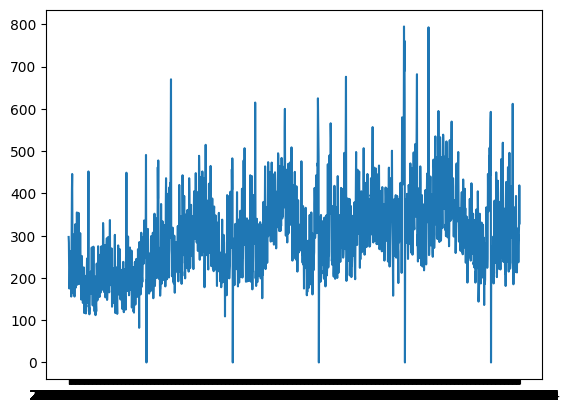

In [7]:
plt.plot(foods_1_fm['date'],foods_1_fm['FOODS_1'])

# Checking for stationarity

In [8]:
#!pip install statsmodels
from statsmodels.tsa.stattools import adfuller
adfuller(foods_1_fm['FOODS_1'])[1]

0.004293354278854091

In [9]:
from statsmodels.tsa.stattools import adfuller
adfuller(foods_1_fm['FOODS_1'])[1]

0.004293354278854091

# Can AR models do the job?

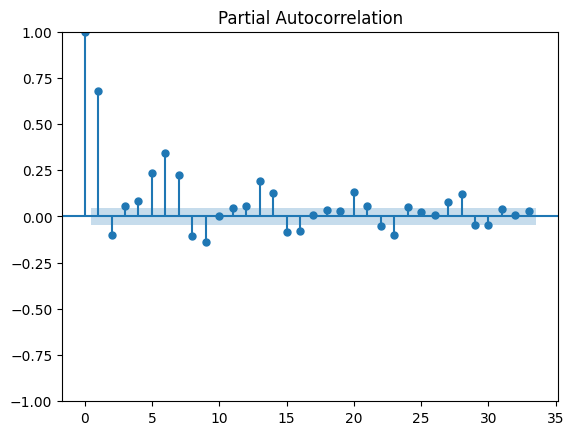

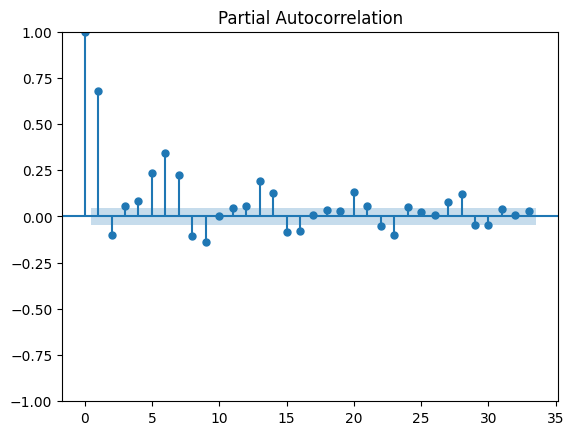

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(foods_1_fm['FOODS_1'])

# Let us try with Auto Arima

In [11]:
from pmdarima.arima import auto_arima

In [12]:
for_arima = foods_1_fm[['date','FOODS_1']]
for_arima['date'] = pd.to_datetime(for_arima['date'])
for_arima.set_index('date',inplace=True)

/tmp/ipykernel_296/3957950523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_arima['date'] = pd.to_datetime(for_arima['date'])


In [13]:
for_arima

,FOODS_1
date,
2011-01-29,297
2011-01-30,284
2011-01-31,214
2011-02-01,175
2011-02-02,182
...,...
2016-04-20,287
2016-04-21,297
2016-04-22,331


In [14]:
train = for_arima[:1800]
test = for_arima[1800:]
model = auto_arima(train, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2,
                   max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2,
                   max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', 
                   alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, 
                   start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None,
                   seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False,
                   random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0,
                   scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None)

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1800
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -9801.291
Date:                Thu, 18 Jul 2024   AIC                          19624.582
Time:                        12:58:51   BIC                          19685.027
Sample:                    01-29-2011   HQIC                         19646.896
                         - 01-02-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3567      0.027     50.100      0.000       1.304       1.410
ar.L2         -1.8816      0.023    -80.816      0.000      -1.927      -1.836
ar.L3          1.5859      0.038     41.260      0.000       1.511       1.661
ar.L4         -1.4246      0.021    -66.672      0.000      -1.467      -1.383
ar.L5          0.5449      0.025     21.858      0.000       0.496       0.594
ma.L1         -1.7753      0.020    -86.907      0.000      -1.815      -1.735
ma.L2          2.1894      0.034     64.912      0.000       2.123       2.255
ma.L3         -2.1338      0.042    -50.714      0.000      -2.216      -2.051
ma.L4          1.6687      0.035     48.186      0.000       1.601       1.737
ma.L5         -0.8926      0.019    -47.972      0.000      -0.929      -0.856
sigma2      3767.7692     74.568     50.528      0.000    3621.619    3913.919
===================================================================================
Ljung-Box (L1) (Q):                   7.66   Jarque-Bera (JB):             10391.66
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
pred = pd.DataFrame(model.predict(n_periods=113),index=test.index)
pred.columns = ['pred_sales']
pred

,pred_sales
date,
2016-01-03,289.400829
2016-01-04,260.600787
2016-01-05,282.622056
2016-01-06,305.408642
2016-01-07,280.653756
...,...
2016-04-20,303.845015
2016-04-21,290.969467
2016-04-22,298.276202


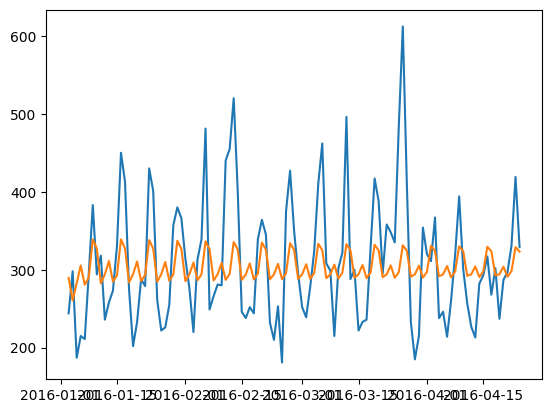

In [17]:
plt.plot(test)
plt.plot(pred)

# Vanilla Univariate LSTM

# The function below enables us to create X and Y pairs that should be fed into our model

In [18]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

In [19]:
split_sequence([1,2,3,4,5,6,7,8,9,10], 3)

(array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]]),
 array([ 4,  5,  6,  7,  8,  9, 10]))

In [20]:
for_arima

,FOODS_1
date,
2011-01-29,297
2011-01-30,284
2011-01-31,214
2011-02-01,175
2011-02-02,182
...,...
2016-04-20,287
2016-04-21,297
2016-04-22,331


In [21]:
X_train, y_train = split_sequence(list(for_arima[:1800]['FOODS_1']), 5)
X_test, y_test = split_sequence(list(for_arima[1800:]['FOODS_1']), 5)

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [23]:
from tensorflow.keras.layers import LSTM

In [24]:
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(5, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

/opt/conda/envs/ct-aiml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
import time

In [26]:
X_train

array([[[297],
        [284],
        [214],
        [175],
        [182]],

       [[284],
        [214],
        [175],
        [182],
        [191]],

       [[214],
        [175],
        [182],
        [191],
        [224]],

       ...,

       [[274],
        [250],
        [200],
        [275],
        [237]],

       [[250],
        [200],
        [275],
        [237],
        [245]],

       [[200],
        [275],
        [237],
        [245],
        [250]]])

In [27]:
X_train.shape

(1795, 5, 1)

In [28]:
# defining callbacks during the training of our model
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch == 0: self.time = time.monotonic()
            
    def on_epoch_end(self, epoch, logs):
        # calculate training time
        t = time.monotonic() - self.time
        # if validation set is included, its loss is recorded in logs['val_loss']
        print('| Epoch {:4} | training time {:6.2f}s | train loss {:6.2f} |'
              .format(epoch, t, logs['loss']))

In [29]:
# Jungha: decreased epochs from 1000 to 100
model.fit(X_train, y_train, epochs=100,callbacks=[PrintLoss()])

Epoch 1/100
29/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110712.1250 | Epoch    0 | training time   1.31s | train loss 67816.39 |
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 96756.4141 
Epoch 2/100
33/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6327.6899 | Epoch    1 | training time   1.46s | train loss 5664.44 |
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6177.5034
Epoch 3/100
38/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4761.2998 | Epoch    2 | training time   1.61s | train loss 5136.58 |
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4889.8149
Epoch 4/100
36/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4965.4033 | Epoch    3 | training time   1.76s | train loss 5186.20 |
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5043.8911
Epoch 5/100
37/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4668.9692 | Epoch    4 | training time   1.92s | train loss 4777.71 |
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4670.7192
Epoch 6/100
38/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5430.2

In [30]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [31]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [32]:
mape(y_test, y_test_pred)

0.1634947232741805

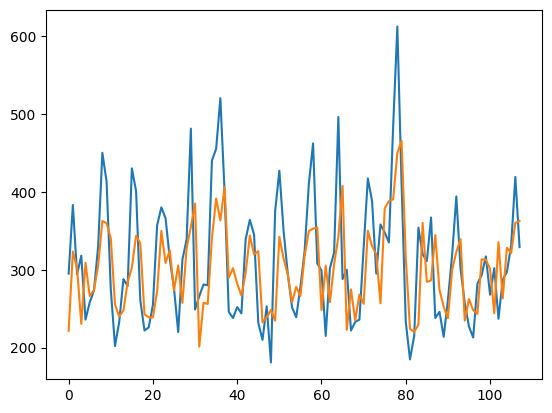

In [33]:
plt.plot(y_test)
plt.plot(y_test_pred)

# Increasing the number of input time sequences

In [34]:
X_train, y_train = split_sequence(list(for_arima[:1800]['FOODS_1']), 20)
X_test, y_test = split_sequence(list(for_arima[1800:]['FOODS_1']), 20)

In [35]:
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(20, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/opt/conda/envs/ct-aiml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [37]:
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch == 0: self.time = time.monotonic()
            
    def on_epoch_end(self, epoch, logs):
        # calculate training time
        t = time.monotonic() - self.time
        # if validation set is included, its loss is recorded in logs['val_loss']
        print('| Epoch {:4} | training time {:6.2f}s | train loss {:6.2f} |'
              .format(epoch, t, logs['loss']))

# Jungha: decreased epochs from 1000 to 100
model.fit(X_train, y_train, epochs=100,callbacks=[PrintLoss()])

Epoch 1/100
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 71009.8750| Epoch    0 | training time   1.20s | train loss 44209.95 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 68715.5000
Epoch 2/100
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6172.2754| Epoch    1 | training time   1.56s | train loss 6062.36 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6159.4028
Epoch 3/100
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4956.8877| Epoch    2 | training time   1.92s | train loss 5233.20 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4971.5894
Epoch 4/100
45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5265.5093| Epoch    3 | training time   2.25s | train loss 9820.84 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6003.6382
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8981.1572| Epoch    4 | training time   2.57s | train loss 6771.97 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8942.3994
Epoch 6/100
50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5300.6748| Ep

In [38]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
mape(y_test, y_test_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


0.15362701712597987

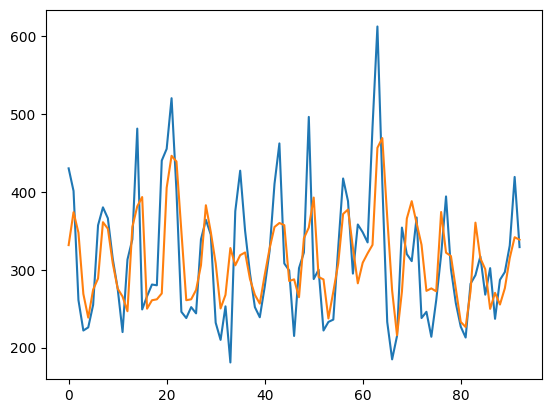

In [39]:
plt.plot(y_test)
plt.plot(y_test_pred)

# Increasing number of lags to 50

In [40]:
X_train, y_train = split_sequence(list(for_arima[:1800]['FOODS_1']), 50)
X_test, y_test = split_sequence(list(for_arima[1800:]['FOODS_1']), 50)
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(50, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Jungha: decreased epochs from 1000 to 100
model.fit(X_train, y_train, epochs=100,callbacks=[PrintLoss()])

Epoch 1/100


/opt/conda/envs/ct-aiml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 75309.1328| Epoch    0 | training time   1.69s | train loss 80852.16 |
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 75507.1016
Epoch 2/100
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 61729.3242| Epoch    1 | training time   2.48s | train loss 51021.00 |
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 61165.1328
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 55365.5742| Epoch    2 | training time   3.28s | train loss 62842.02 |
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 55499.0820
Epoch 4/100
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 66299.0625| Epoch    3 | training time   4.02s | train loss 63065.93 |
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 66129.8203
Epoch 5/100
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 46892.5742| Epoch    4 | training time   4.75s | train loss 44141.42 |
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 46746.9492
Epoch 6/100
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 37

In [41]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
mape(y_test, y_test_pred)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f8544290040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


0.1591895813354201

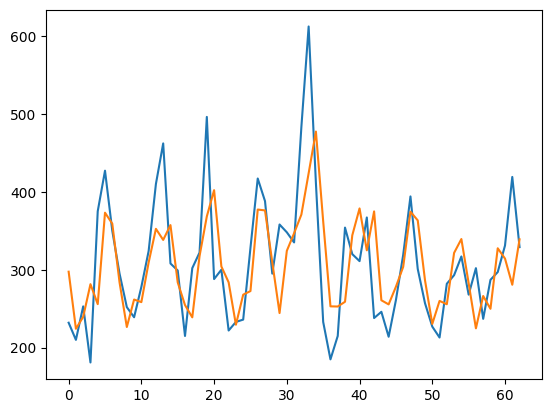

In [42]:
plt.plot(y_test)
plt.plot(y_test_pred)

# Vanilla LSTM 30 lags (best)

# Architrcure 1 - 50 LSTM input units

In [43]:
X_train, y_train = split_sequence(list(for_arima[:1800]['FOODS_1']), 30)
X_test, y_test = split_sequence(list(for_arima[1800:]['FOODS_1']), 30)
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(30, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# Jungha: decreased epochs from 500 to 100
model.fit(X_train, y_train, epochs=100,callbacks=[PrintLoss()])

Epoch 1/100


/opt/conda/envs/ct-aiml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 74398.8438| Epoch    0 | training time   1.24s | train loss 51326.47 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 73185.3125
Epoch 2/100
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27289.5430| Epoch    1 | training time   1.66s | train loss 31239.30 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27634.6953
Epoch 3/100
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28555.9492| Epoch    2 | training time   2.07s | train loss 25979.89 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28421.1094
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31171.5430| Epoch    3 | training time   2.47s | train loss 27272.37 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31103.1367
Epoch 5/100
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15758.7119| Epoch    4 | training time   2.88s | train loss 14710.27 |
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15686.4902
Epoch 6/100
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10452.6016| E

In [44]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)
mape(y_test, y_test_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


0.21699867871288903

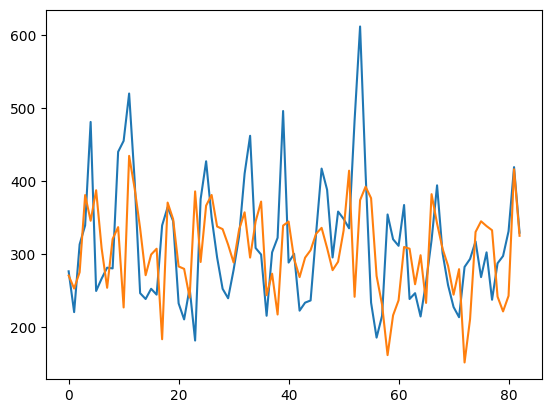

In [45]:
plt.plot(y_test)
plt.plot(y_test_pred)

# Architecture 2 100 input LSTM units - best

In [46]:
X_train, y_train = split_sequence(list(for_arima[:1800]['FOODS_1']), 30)
X_test, y_test = split_sequence(list(for_arima[1800:]['FOODS_1']), 30)
model = tf.keras.Sequential()
model.add(LSTM(100, activation='relu', input_shape=(30, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/opt/conda/envs/ct-aiml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [49]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
filepath="weights-improvement-{epoch:02d}-{loss:.2f}.weights.h5"
# Jungha
# filepath must end in.keras unless only weights are saved
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
model.fit(X_train, y_train, epochs=100,callbacks=[checkpoint])

Epoch 1/100
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 121457.2969
Epoch 1: loss improved from inf to 118910.78906, saving model to weights-improvement-01-118910.79.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 121367.9453
Epoch 2/100
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 79733.9844
Epoch 2: loss improved from 118910.78906 to 69785.61719, saving model to weights-improvement-02-69785.62.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 79037.9766
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 44603.4297
Epoch 3: loss improved from 69785.61719 to 54643.55859, saving model to weights-improvement-03-54643.56.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 44779.5742
Epoch 4/100
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 47524.8555
Epoch 4: loss improved from 54643.55859 to 45846.71094, saving model to weights-improvement-04-45846.71.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 47412.8008
Epoch 5/100
53/56 ━━━━━

In [50]:
model.compile(optimizer='adam', loss='mse')

In [51]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred= model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [52]:
mape(y_test, y_test_pred)

0.20737181077919126

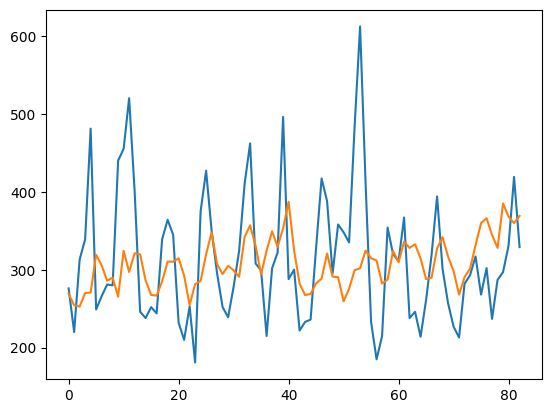

In [53]:
plt.plot(y_test)
plt.plot(y_test_pred)

In [54]:
foods_1_fm['event_1'] = foods_1_fm['event_name_1']+foods_1_fm['event_type_1']
foods_1_fm['event_2'] = foods_1_fm['event_name_2']+foods_1_fm['event_type_2']

foods_1_fm.drop(['event_name_1','event_type_1','event_name_2','event_type_2','wm_yr_wk'],axis=1,inplace=True)

foods_1_fm = pd.concat([foods_1_fm,pd.get_dummies(foods_1_fm[['weekday','month','event_1','event_2']],drop_first=True)],axis=1)

foods_1_fm.drop(['weekday','month','event_1','event_2','year'],axis=1,inplace=True)

foods_1_fm.set_index('date',inplace=True)

In [60]:
#Jungha debug
# X_train = X_train.astype('float32')
# y_train = np.asarray(y_train).astype('float32')
print(tf.shape(X_train))
print(tf.shape(y_train))
filepath="cnn-{epoch:02d}-{val_loss:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train,
                    batch_size=10, epochs=100,validation_split=0.1,callbacks=[checkpoint])

tf.Tensor([1770   30    1], shape=(3,), dtype=int32)
tf.Tensor([1770], shape=(1,), dtype=int32)
Epoch 1/100
152/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33829.2695
Epoch 1: val_loss improved from inf to 28134.58398, saving model to cnn-01-28134.58.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 34022.1445 - val_loss: 28134.5840
Epoch 2/100
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1851304.5000
Epoch 2: val_loss did not improve from 28134.58398
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1831869.1250 - val_loss: 29162.6309
Epoch 3/100
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 201913.0938
Epoch 3: val_loss did not improve from 28134.58398
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 201047.2812 - val_loss: 102458.8828
Epoch 4/100
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 79551.9609
Epoch 4: val_loss improved from 28134.58398 to 25318.17773, saving model to cnn-04-25318.18.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 78641.5312 - val_loss

In [57]:
#model.load_weights("cnn-167-4008.38.keras")
model.compile(optimizer='adam', loss='mse')
X_test = np.array(X_test)
y_test_pred= model.predict(X_test)
y_test_pred = [i[0] for i in y_test_pred]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [58]:
mape(y_test,y_test_pred)

0.342804791600934

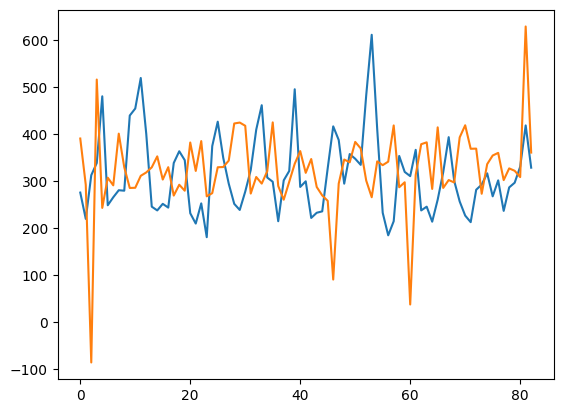

In [59]:
plt.plot(y_test)
plt.plot(y_test_pred)